In [1]:
import os
import numpy as np
import pandas as pd
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model

### Read the masks from the json file

In [2]:
json_path = 'unet_images_dataset/train/_annotations.coco.json'

with open(json_path,'r') as file:
    data = json.load(file)

In [3]:
data.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [4]:
data['images'][:5]

[{'id': 0,
  'license': 1,
  'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2023-08-19T04:37:54+00:00'},
 {'id': 1,
  'license': 1,
  'file_name': '2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2023-08-19T04:37:54+00:00'},
 {'id': 2,
  'license': 1,
  'file_name': '2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2023-08-19T04:37:54+00:00'},
 {'id': 3,
  'license': 1,
  'file_name': '2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2023-08-19T04:37:54+00:00'},
 {'id': 4,
  'license': 1,
  'file_name': '2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg',
  'height': 640,
  'width': 640,
  'date_captured': '2023-08-19T04:37:54+00:00'}]

In [5]:
data['annotations'][:5]

[{'id': 0,
  'image_id': 0,
  'category_id': 1,
  'bbox': [145, 239, 168.75, 162.5],
  'area': 27421.875,
  'segmentation': [[313.75,
    238.75,
    145,
    238.75,
    145,
    401.25,
    313.75,
    401.25,
    313.75,
    238.75]],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 1,
  'category_id': 1,
  'bbox': [194, 176, 148.75, 233.75],
  'area': 34770.313,
  'segmentation': [[342.5,
    176.25,
    193.75,
    176.25,
    193.75,
    410,
    342.5,
    410,
    342.5,
    176.25]],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 2,
  'category_id': 1,
  'bbox': [133, 173, 162.5, 185],
  'area': 30062.5,
  'segmentation': [[295,
    172.5,
    132.5,
    172.5,
    132.5,
    357.5,
    295,
    357.5,
    295,
    172.5]],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 3,
  'category_id': 1,
  'bbox': [245, 358, 138.75, 166.25],
  'area': 23067.188,
  'segmentation': [[383.75,
    357.5,
    245,
    357.5,
    245,
    523.75,
    383.75,
    523.75,
    383.75,
    357.5]],
  'iscrowd': 0},

In [6]:
# Save the names of the images in a list
train_dir = 'unet_images_dataset/train/'
train_img_names = [img['file_name'] for img in data['images']]

print('N_train =', len(train_img_names))
print(train_img_names[:5])

N_train = 1502
['2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', '2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg', '2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg', '2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg', '2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg']


In [7]:
def extract_maskbox(img_path, data):
    img_name = os.path.basename(img_path)
    img_id = [item for item in data['images'] if item['file_name'] == img_name][0]['id']
    img_mask = [item for item in data['annotations'] if item['image_id'] == img_id]

    # Extract the coordinates of the box
    points_list = img_mask[0]['segmentation']
    mask_box = np.array(points_list, np.int32)
    mask_box = mask_box.reshape((-1, 1, 2))
    return mask_box

In [8]:
def draw_maskbox(img_path, mask_box):
    img = cv2.imread(img_path)

    # Draw the box on top of the image
    fig, ax = plt.subplots(figsize = (5, 5))
    cv2.polylines(img, [mask_box], True, (0, 0, 255), 3)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [9]:
def create_mask(img_path, mask_box):
    img_shape = np.asarray(cv2.imread(img_path)).shape

    mask_img = np.zeros((img_shape[0], img_shape[1]))
    try:
        up_right = mask_box[0][0]
        up_left = mask_box[1][0]
        down_left = mask_box[2][0]
        down_right = mask_box[3][0]
        mask_img[up_left[1]:down_left[1], up_left[0]:up_right[0]] = 1
    except:
        pass
    return mask_img

In [10]:
train_img = []
train_box = []
train_mask = []
for img_name in train_img_names:
    img = np.asarray(cv2.imread(train_dir+img_name))/255
    flatten_img = img.mean(axis = 2)
    train_img.append(flatten_img)
    try:
        mask_box = extract_maskbox(train_dir+img_name, data)
    except:
        mask_box = []
    
    train_box.append(mask_box)
    mask_img = create_mask(train_dir+img_name, mask_box)
    train_mask.append(mask_img)

train_img = np.array(train_img)
train_mask = np.array(train_mask)

print('Shape =', train_img[0].shape)
train_box[0]

Shape = (640, 640)


array([[[313, 238]],

       [[145, 238]],

       [[145, 401]],

       [[313, 401]],

       [[313, 238]]])

[[[395 230]]

 [[291 230]]

 [[291 307]]

 [[395 307]]

 [[395 230]]]


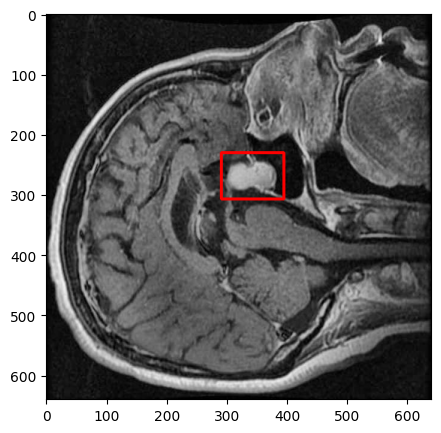

In [11]:
idx = 255

print(train_box[idx])
draw_maskbox(train_dir+train_img_names[idx], train_box[idx])

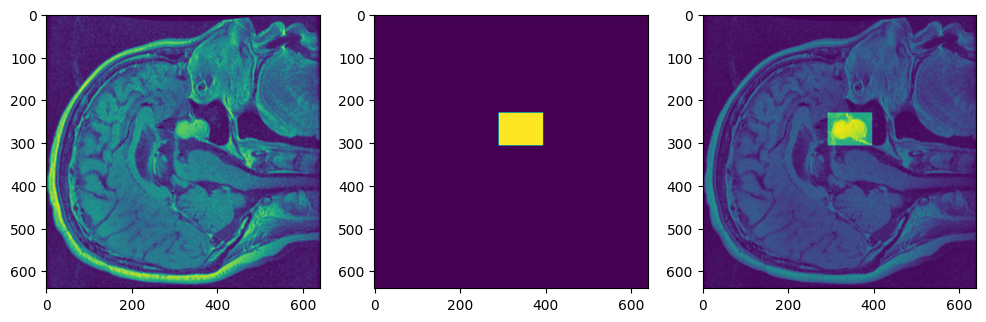

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))
ax[0].imshow(train_img[idx])
ax[1].imshow(train_mask[idx])
ax[2].imshow(train_img[idx] + train_mask[idx])

plt.show()

In [13]:
# Read the testidation set
json_path = 'unet_images_dataset/valid/_annotations.coco.json'
with open(json_path,'r') as file:
    data = json.load(file)

val_dir = 'unet_images_dataset/valid/'
val_img_names = [img['file_name'] for img in data['images']]

print('N_val =', len(val_img_names))
print(val_img_names[:5])

N_val = 429
['1997_jpg.rf.57e306420710246d04c0d5c26e6496c6.jpg', '2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg', '1630_jpg.rf.5afc6e25d7987503a11bcb0791b60b53.jpg', '1330_jpg.rf.5b23bf18a29b0f50e376b19a5a84f823.jpg', '2768_jpg.rf.5b87c0023909e0789a33185a3aab92e9.jpg']


In [14]:
val_img = []
val_mask = []
for img_name in val_img_names:
    img = np.asarray(cv2.imread(val_dir+img_name))/255
    flatten_img = img.mean(axis = 2)
    val_img.append(flatten_img)
    try:
        mask_box = extract_maskbox(val_dir+img_name, data)
    except:
        mask_box = []
    
    mask_img = create_mask(val_dir+img_name, mask_box)
    val_mask.append(mask_img)

val_img = np.array(val_img)
val_mask = np.array(val_mask)

print('Shape =', val_img[0].shape)

Shape = (640, 640)


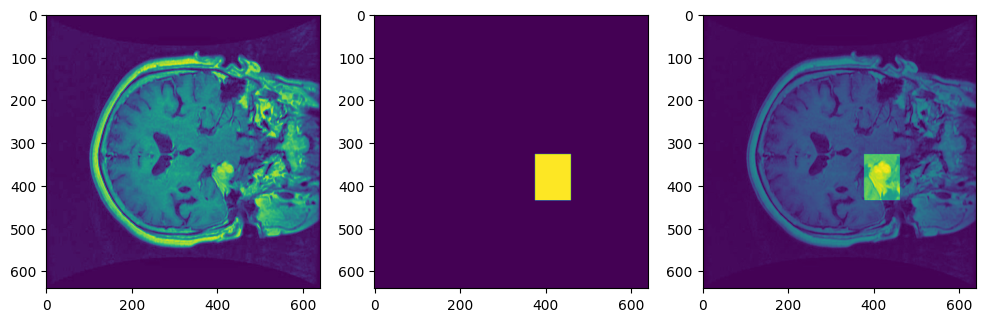

In [15]:
idx = 127

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))
ax[0].imshow(val_img[idx])
ax[1].imshow(val_mask[idx])
ax[2].imshow(val_img[idx] + val_mask[idx])

plt.show()

### Create the model

In [16]:
def unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u2 = UpSampling2D((2, 2))(c3)
    u2 = concatenate([u2, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    u1 = UpSampling2D((2, 2))(c4)
    u1 = concatenate([u1, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(c5)

    # Output Layer (Binary classification, so we use sigmoid)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    # Create Model
    model = Model(inputs, outputs)
    
    return model

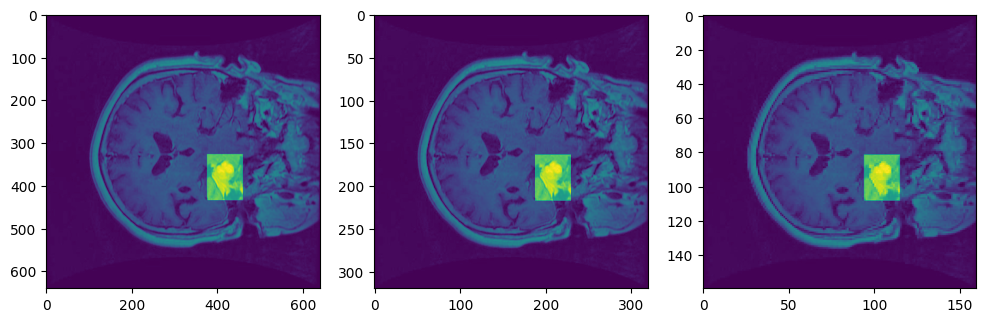

In [17]:
# We need to downsample the images for practical purpose for the moment
idx = 127

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))
ax[0].imshow(val_img[idx] + val_mask[idx])
ax[1].imshow(val_img[idx][0::2, 0::2] + val_mask[idx][0::2, 0::2])
ax[2].imshow(val_img[idx][0::2, 0::2][0::2, 0::2] + val_mask[idx][0::2, 0::2][0::2, 0::2])

plt.show()

New shapes = (1502, 160, 160, 1)


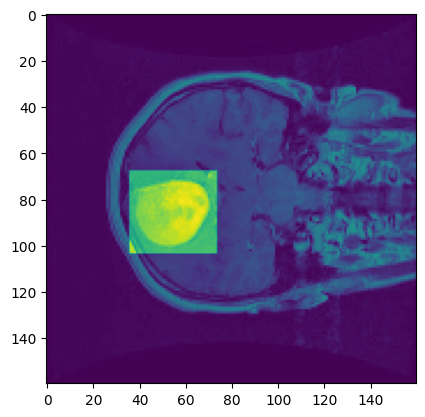

In [18]:
downsampled_train_img = train_img[:, 0::2, 0::2][:, 0::2, 0::2].reshape(-1, 160, 160, 1)
downsampled_train_mask = train_mask[:, 0::2, 0::2][:, 0::2, 0::2].reshape(-1, 160, 160, 1)
downsampled_val_img = val_img[:, 0::2, 0::2][:, 0::2, 0::2].reshape(-1, 160, 160, 1)
downsampled_val_mask = val_mask[:, 0::2, 0::2][:, 0::2, 0::2].reshape(-1, 160, 160, 1)

print('New shapes =', downsampled_train_img.shape)

plt.imshow(downsampled_train_img[idx] + downsampled_train_mask[idx])
plt.show()

In [19]:
# Clear any built model
tf.keras.backend.clear_session()

In [20]:
# Define the input shape of your images, for example (128, 128, 3) for RGB images.
input_shape = (160, 160, 1)
model = unet(input_shape)

# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 160, 160,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 160,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 80, 80,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 80,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 40, 40,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 40,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 40,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 80, 80,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80, 80,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 80, 80,    │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 80, 80,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 160, 160,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160, 160,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 160, 160,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 160, 160,  │      2,320 │ conv2d_8[0][0]  

 Total params: 117,985 (460.88 KB)

 Trainable params: 117,985 (460.88 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
history = model.fit(downsampled_train_img[:500], downsampled_train_mask[:500],
                    validation_data = (downsampled_val_img[:50], downsampled_val_mask[:50]),
                    batch_size = 32, epochs = 30)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9268 - loss: 0.5579 - val_accuracy: 0.9629 - val_loss: 0.2215
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9632 - loss: 0.1869 - val_accuracy: 0.9629 - val_loss: 0.1399
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9625 - loss: 0.1389 - val_accuracy: 0.9629 - val_loss: 0.1380
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9629 - loss: 0.1350 - val_accuracy: 0.9629 - val_loss: 0.1338
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9612 - loss: 0.1365 - val_accuracy: 0.9629 - val_loss: 0.1309
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.9636 - loss: 0.1298 - val_accuracy: 0.9629 - val_loss: 0.1298
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.9627 - loss: 0.1299 - val_accuracy: 0.9629 - val_loss: 0.1297
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.9639 - loss: 0.1276 - val_accuracy: 0.9629 - val_loss:

In [22]:
# Read the validation set
json_path = 'unet_images_dataset/test/_annotations.coco.json'
with open(json_path,'r') as file:
    data = json.load(file)

test_dir = 'unet_images_dataset/test/'
test_img_names = [img['file_name'] for img in data['images']]

print('N_test =', len(test_img_names))
print(test_img_names[:5])

N_test = 215
['1706_jpg.rf.004b87f63425ef145855aab826e33eee.jpg', '1363_jpg.rf.01c4537b57f360820b9e00c7e0c99ae1.jpg', '1136_jpg.rf.02df64849485272e48139498c36c8e44.jpg', '2210_jpg.rf.039c38182fe783c69dd28160e5ef02a0.jpg', '2058_jpg.rf.04e8e79db0fbf2459585ce3954f50739.jpg']


In [23]:
test_img = []
test_mask = []
for img_name in test_img_names:
    img = np.asarray(cv2.imread(test_dir+img_name))/255
    flatten_img = img.mean(axis = 2)
    test_img.append(flatten_img)
    try:
        mask_box = extract_maskbox(test_dir+img_name, data)
    except:
        mask_box = []
    
    mask_img = create_mask(test_dir+img_name, mask_box)
    test_mask.append(mask_img)

test_img = np.array(test_img)
test_mask = np.array(test_mask)

print('Shape =', test_img[0].shape)

Shape = (640, 640)


In [24]:
# Downsample and reshape the test set
downsampled_test_img = test_img[:, 0::2, 0::2][:, 0::2, 0::2].reshape(-1, 160, 160, 1)
downsampled_test_mask = test_mask[:, 0::2, 0::2][:, 0::2, 0::2].reshape(-1, 160, 160, 1)

print('New shape =', downsampled_test_img.shape)

New shape = (215, 160, 160, 1)


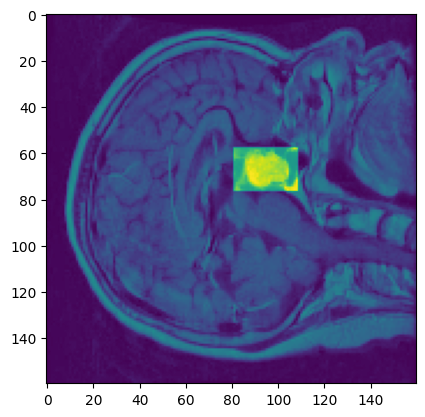

In [25]:
plt.imshow(downsampled_test_img[0] + downsampled_test_mask[0])

In [26]:
def model_predict(img):
    prediction = model.predict(np.expand_dims(img, axis = 0))[0]
    prediction = (prediction > 0.5).astype(np.uint8)
    return prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


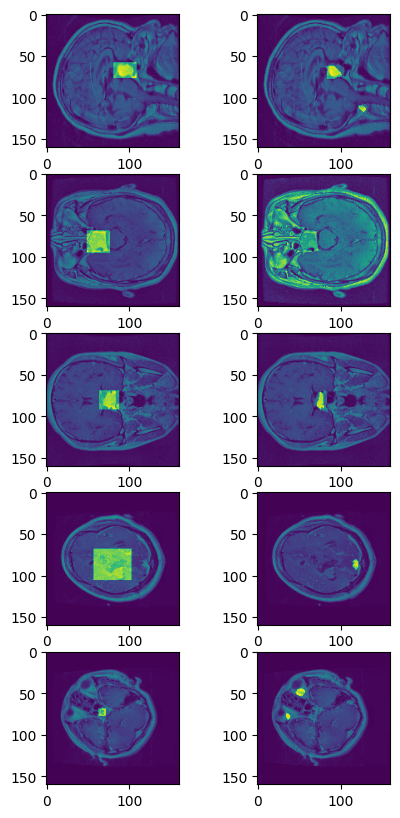

In [27]:
# Make predictions
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (5, 10))

for i in range(5):
    prediction = model_predict(downsampled_test_img[i])

    ax[i, 0].imshow(downsampled_test_img[i] + downsampled_test_mask[i])
    ax[i, 1].imshow(downsampled_test_img[i] + prediction)

plt.show()